In [2]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from itertools import cycle
from io import StringIO
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

In [18]:
############################################# initialize the data #############################################


# electrode_df = pd.read_csv("/Users/siyuanzhao/Documents/GitHub/CS529_VDS_Epilepsy/frontend/src/data/electrodes/ep129/ep129_rois_kmeans.csv")
# electrode_df = pd.read_csv("/Users/siyuanzhao/Documents/GitHub/CS529_VDS_Epilepsy/frontend/src/data/electrodes/ep187/ep187_rois_kmeans.csv")
# electrode_df = pd.read_csv("/Users/siyuanzhao/Documents/GitHub/CS529_VDS_Epilepsy/frontend/src/data/electrodes/ep162/ep162_rois_kmeans.csv")
electrode_df = pd.read_csv("/Users/siyuanzhao/Documents/GitHub/CS529_VDS_Epilepsy/frontend/src/data/electrodes/ep164/ep164_rois_kmeans.csv")
# electrode_df = pd.read_csv("/Users/siyuanzhao/Documents/GitHub/CS529_VDS_Epilepsy/frontend/src/data/electrodes/ep165/ep165_rois_kmeans.csv")

electrode_df['E_Brain'] = electrode_df['E_Brain'].str.replace('\d+', '', regex=True)

# ep129 top-bottom divided by region
# top_bottom_df = electrode_df[electrode_df['label'].isin([1])]
# left_right_df = electrode_df[~electrode_df['label'].isin([1])]

# ep187 top-bottom divided by region
# top_bottom_df = electrode_df[electrode_df['label'].isin([6, 9, 8, 10, 2, 4])]
# left_right_df = electrode_df[~electrode_df['label'].isin([6, 9, 8, 10, 2, 4])]

# ep162 top-bottom divided by region
# top_bottom_df = electrode_df[electrode_df['label'].isin([0, 1])]
# left_right_df = electrode_df[~electrode_df['label'].isin([0, 1])]

# ep164 top-bottom divided by region
top_bottom_df = electrode_df[electrode_df['label'].isin([0, 1])]
left_right_df = electrode_df[~electrode_df['label'].isin([0, 1])]

# ep165 top-bottom divided by region
# top_bottom_df = electrode_df[electrode_df['label'].isin([1])]
# left_right_df = electrode_df[~electrode_df['label'].isin([1])]

# find the unique labels for creating arrays
top_bottom_df_label_array = top_bottom_df['label'].unique()
left_right_df_label_array = left_right_df['label'].unique()

8.225513893161807 13.225513893161807 left-right threshold
Label 2 is oriented Horizontal
[56, 55] patch summary
[57, 58, 59, 60, 61] patch summary
[65, 66, 67, 68, 69, 70, 71] patch summary
[73, 74, 75, 76, 77, 78, 79, 80] patch summary
[81, 82, 83, 84, 85, 86, 87, 88] patch summary
[89, 90, 91, 92, 93, 94, 95, 96] patch summary
[97, 98, 99, 100, 101, 102, 103, 104] patch summary
[105, 106, 107, 108, 109, 110, 111, 112] patch summary
[113, 114, 115, 116, 117, 118, 119, 120] patch summary


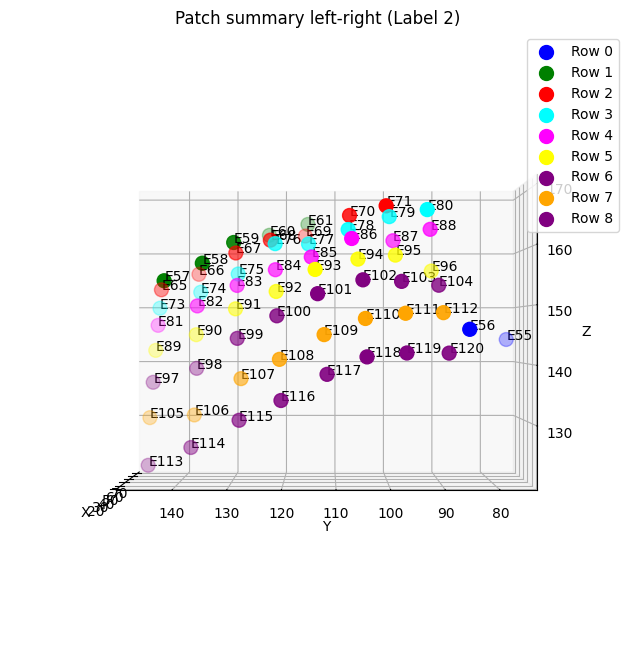

6.809602203132275 14.809602203132275 top-bottom threshold
[8, 7, 6, 5, 4, 3, 2, 1] patch summary
[16, 15, 14, 13, 12, 11, 10, 9] patch summary
[20, 19, 18, 17] patch summary
[24, 23, 22, 21] patch summary
[62, 63, 72, 64] patch summary


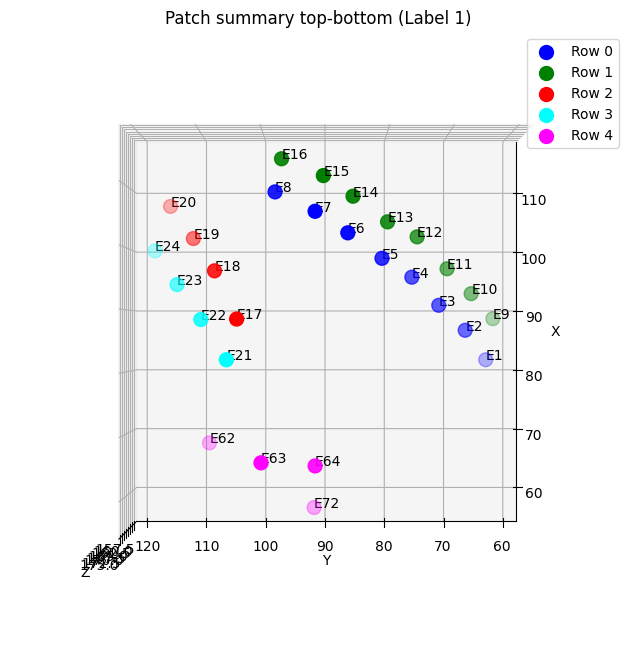

8.383659385338136 16.383659385338134 top-bottom threshold
[34, 33, 32, 31, 30, 29, 28, 27, 26, 25] patch summary
[35, 36, 37, 38, 40, 39] patch summary
[48, 47, 46, 41, 43, 45, 44, 42] patch summary
[54, 53, 52, 51, 50, 49] patch summary


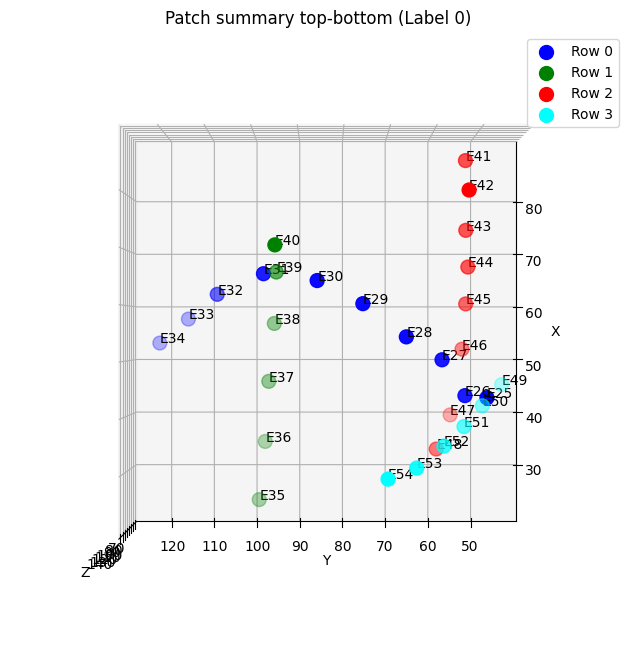

{'2': {'view': 'left-right',
  'orientation': 'Horizontal',
  'matrix': [[57, 58, 59, 60, 61, None, None, None],
   [65, 66, 67, 68, 69, 70, 71, None],
   [73, 74, 75, 76, 77, 78, 79, 80],
   [81, 82, 83, 84, 85, 86, 87, 88],
   [None, None, None, None, None, None, None, 55],
   [89, 90, 91, 92, 93, 94, 95, 96],
   [97, 98, 99, 100, 101, 102, 103, 104],
   [105, 106, 107, 108, 109, 110, 111, 112],
   [113, 114, 115, 116, 117, 118, 119, 120]]},
 '1': {'view': 'top-bottom',
  'orientation': 'Horizontal',
  'matrix': [[16, 15, 14, 13, 12, 11, 10, 9],
   [8, 7, 6, 5, 4, 3, 2, 1],
   [20, 19, 18, 17, None, None, None, None],
   [24, 23, 22, 21, None, None, None, None],
   [62, 63, 72, 64, None, None, None, None]]},
 '0': {'view': 'top-bottom',
  'orientation': 'Horizontal',
  'matrix': [[34, 33, 32, 31, 30, 29, 28, 27, 26, 25],
   [None, None, None, None, None, None, None, 48, 47, 42],
   [None, None, None, None, None, 54, 53, None, None, 49],
   [None, None, 35, 36, 37, 38, 40, 39, None, N

In [19]:
colors = ["blue", "green", "red", "cyan", "magenta", "yellow", "purple", "orange", "purple"]
# colors = ["#d53e4f", "#f46d43", "#4d9221", "#2166ac", "#762a83", "#abdda4", "#66c2a5", "#3288bd"]

# Initialize the final dictionary to store electrode groups
electrode_groups = {}


def update_electrode_groups(view, label, matrix, orientation):
    # Update the electrode_groups dictionary
    electrode_groups[label] = {
        "view": view,
        "orientation": orientation,
        "matrix": matrix,
    }


# Determine whether it is horizontal or vertical when view is from left to right
def left_right_determine_orientation(group_df):
    y_std = group_df["Y"].std()
    z_std = group_df["Z"].std()

    if y_std > z_std:
        return "Horizontal"
    else:
        return "Vertical"


# Determine whether it is horizontal or vertical when view is from top to bottom
def top_bottom_determine_orientation(group_df):
    x_std = group_df["X"].std()
    y_std = group_df["Y"].std()

    if x_std > y_std:
        return "Vertical"
    else:
        return "Horizontal"


def intercept_with_z_axis(df, orientation):
    intercepts = []
    for i in range(len(df)):
        for j in range(i + 1, len(df)):
            x1, y1, z1 = df.iloc[i][["X", "Y", "Z"]]
            x2, y2, z2 = df.iloc[j][["X", "Y", "Z"]]

            if x1 != x2:
                if orientation == "Horizontal":
                    k = (z2 - z1) / (y2 - y1)
                    b = z1 - k * y1
                    intercepts.append(b)
                else:
                    k = (x2 - x1) / (y2 - y1)
                    b = x1 - k * y1
                    intercepts.append(b)

    return max(intercepts) if intercepts else float("-inf")


def calculate_distance(e1, e2, orientation):
    # Extract coordinates
    pos1, pos2 = electrode_positions[e1], electrode_positions[e2]
    if orientation == "Horizontal":
        # Calculate distance in the Y-Z plane
        return np.sqrt((pos1["Y"] - pos2["Y"]) ** 2 + (pos1["Z"] - pos2["Z"]) ** 2)
    else:
        # Calculate distance in the X-Y plane
        return np.sqrt((pos1["X"] - pos2["X"]) ** 2 + (pos1["Y"] - pos2["Y"]) ** 2)


# def align_matrix(matrix, orientation):
#     # Identify the row with the maximum electrodes
#     max_row_length = max(len(row) for row in matrix)
#     longest_row = max(matrix, key=len)

#     # Initialize aligned matrix with placeholders
#     aligned_matrix = [[None] * max_row_length for _ in range(len(matrix))]

#     for i, row in enumerate(matrix):
#         # Track the last placed index for the current row
#         last_placed_index = -1
#         for j, electrode in enumerate(row):
#             if len(row) == max_row_length:
#                 # Directly copy the longest row to the aligned matrix
#                 aligned_matrix[i][j] = electrode
#             else:
#                 # Find the closest electrode in the longest row
#                 distances = [
#                     calculate_distance(electrode, e, orientation) for e in longest_row
#                 ]
#                 min_distance_index = distances.index(min(distances))
#                 print(electrode, distances, min_distance_index)
#                 # Place electrode in the column of the closest electrode
#                 # while aligned_matrix[i][min_distance_index] is not None:
#                 while (aligned_matrix[i][min_distance_index] is not None or min_distance_index < last_placed_index):
#                     distances[min_distance_index] = float("inf")
#                     min_distance_index = distances.index(min(distances))

#                 aligned_matrix[i][min_distance_index] = electrode
#                 last_placed_index = min_distance_index

#     return aligned_matrix

def align_matrix(matrix, orientation):
    # Identify the row with the maximum electrodes
    max_row_length = max(len(row) for row in matrix)
    longest_row = max(matrix, key=len)

    # Initialize aligned matrix with placeholders
    aligned_matrix = [[None] * max_row_length for _ in range(len(matrix))]

    for i, row in enumerate(matrix):
        # Track the last placed index for the current row
        last_placed_index = -1
        used_indices = set()
        
        for j, electrode in enumerate(row):
            if len(row) == max_row_length:
                # Directly copy the longest row to the aligned matrix
                aligned_matrix[i][j] = electrode
            else:
                # Find the closest electrode in the longest row
                distances = [
                    calculate_distance(electrode, e, orientation) for e in longest_row
                ]
                
                # Sort the indices by their distances to the electrode
                sorted_indices = sorted(range(len(distances)), key=lambda k: distances[k])
                
                # Find the first available index that hasn't been used yet and is greater than last_placed_index
                for index in sorted_indices:
                    if index not in used_indices and index > last_placed_index:
                        min_distance_index = index
                        break

                # Place electrode in the column of the closest electrode
                aligned_matrix[i][min_distance_index] = electrode
                used_indices.add(min_distance_index)
                last_placed_index = min_distance_index

    return aligned_matrix


# Only transform matrices for labels with 'Vertical' orientation and more than one row
def transpose_and_pair_vertical_matrices_conditionally(electrode_groups):
    for label, info in electrode_groups.items():
        if info["orientation"] == "Vertical":
            original_matrix = info["matrix"]
            # Check if the matrix represents more than one row
            is_multi_row = len(original_matrix) > 1 and any(
                len(row) > 1 for row in original_matrix
            )

            # Only proceed with matrices that are not a single vertical line
            if is_multi_row:
                # Find the maximum length among all rows
                max_length = max(len(row) for row in original_matrix)
                transposed_matrix = []

                # Transpose the matrix
                for i in range(max_length):
                    new_row = [
                        row[i] if i < len(row) else None for row in original_matrix
                    ]
                    transposed_matrix.append(new_row)

                # Update the matrix in the original dictionary
                info["matrix"] = transposed_matrix


# Visualization
def visualize_group(angle):
    for group in unique_groups:
        group_df = sorted_df[sorted_df["group"] == group]
        color = colors[unique_groups.tolist().index(group)]
        ax.scatter(
            group_df["X"],
            group_df["Y"],
            group_df["Z"],
            s=100,
            color=color,
            label=f"Row {group}",
        )
        for _, row in group_df.iterrows():
            ax.text(
                row["X"],
                row["Y"],
                row["Z"],
                f"E{row['electrode_number']}",
                color="black",
            )

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    # ax.set_xticks([])
    plt.title(f"Patch summary {angle} (Label {label})")
    # plt.title(f'Row Groupping', fontsize=12, loc='center')
    plt.legend()
    plt.show()

# ========================================================================================================================================================================================================================================================
#
#
# Loop through each brain region for left and right view angle
#
#
# ========================================================================================================================================================================================================================================================
for label in left_right_df_label_array:
    # Filter the dataframe for the current label
    filtered_df = left_right_df[left_right_df["label"] == label]

    # Current label electrode dataframe
    sorted_df = filtered_df.sort_values(by="electrode_number")

    # Initialize a group label and assign group labels
    group_label = 0
    sorted_df["group"] = -1

    # Calculate distances and define yz_threshold
    distances = np.sqrt((np.diff(sorted_df["Z"]) ** 2) + (np.diff(sorted_df["Y"]) ** 2))
    Q1, Q3 = np.percentile(distances, [25, 75])
    IQR = Q3 - Q1
    filtered_distances = distances[
        (distances >= Q1 - 1.5 * IQR) & (distances <= Q3 + 1.5 * IQR)
    ]
    yz_threshold = np.mean(filtered_distances) + 5
    print(np.mean(filtered_distances), yz_threshold, "left-right threshold")

    for i in range(len(sorted_df)):
        if i == 0:
            sorted_df.iloc[i, sorted_df.columns.get_loc("group")] = group_label
        else:
            distance = np.sqrt(
                (sorted_df.iloc[i]["Z"] - sorted_df.iloc[i - 1]["Z"]) ** 2
                + (sorted_df.iloc[i]["Y"] - sorted_df.iloc[i - 1]["Y"]) ** 2
            )
            if (distance > yz_threshold) | (
                sorted_df.iloc[i]["electrode_number"]
                - sorted_df.iloc[i - 1]["electrode_number"]
                > 1
            ):
                group_label += 1
            sorted_df.iloc[i, sorted_df.columns.get_loc("group")] = group_label

    # Visualization setup
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection="3d")

    # left to right
    ax.view_init(elev=0, azim=180)

    unique_groups = sorted_df["group"].unique()

    #################################### if only one group for a label ####################################
    if len(unique_groups) == 1:
        group_df = sorted_df[sorted_df["group"] == unique_groups[0]]
        orientation = left_right_determine_orientation(group_df)
        print(f"Label {label} is oriented {orientation}")

        # Update electrode_groups based on orientation
        if orientation == "Vertical":
            # Sort electrodes by Z-axis in descending order and place each in its own sublist
            sorted_electrodes = group_df.sort_values(by="Z", ascending=False)[
                "electrode_number"
            ].tolist()
            electrode_groups[str(label)] = [[elec] for elec in sorted_electrodes]
            print(electrode_groups[str(label)], "patch summary")
            update_electrode_groups(
                "left-right", str(label), electrode_groups[str(label)], orientation
            )

        else:
            # Sort electrodes by Y-axis in ascending order and place all in a single sublist
            sorted_electrodes = group_df.sort_values(by="Y", ascending=True)[
                "electrode_number"
            ].tolist()
            print(sorted_electrodes, "patch summary")
            electrode_groups[str(label)] = [sorted_electrodes]
            update_electrode_groups(
                "left-right", label, electrode_groups[str(label)], orientation
            )

    #################################### if it has multiple groups ####################################
    else:
        # Determine the orientation of the first group
        horizontal_numbers = 0
        vertical_numbers = 0
        for group in unique_groups:
            group_df = sorted_df[sorted_df["group"] == group]
            orientation = left_right_determine_orientation(group_df)
            if orientation == "Horizontal":
                horizontal_numbers += 1
            else:
                vertical_numbers += 1
        if horizontal_numbers > vertical_numbers:
            group_orientation = "Horizontal"
        else:
            group_orientation = "Vertical"
        print(f"Label {label} is oriented {group_orientation}")

        # If the first group is horizontal, rearrange based on Z-axis average
        if group_orientation == "Horizontal":
            # Calculate the average Z-axis value for each group
            avg_z_by_group = sorted_df.groupby('group')
            
            # Reorder the groups based on the sorted average Z-axis values
            reordered_groups = []
            # for group in avg_z_by_group.index:
            for group in range(len(avg_z_by_group)):
                group_electrodes = (
                    sorted_df[sorted_df["group"] == group]
                    .sort_values(by="Y", ascending=False)["electrode_number"]
                    .tolist()
                )
                print(group_electrodes, "patch summary")
                reordered_groups.append(group_electrodes)
            
            reordered_groups = sorted(reordered_groups, key=lambda electrodes: sorted_df.loc[sorted_df["electrode_number"] == electrodes[0], "Z"].values[0], reverse=True)
            # Update the electrode_groups dictionary
            electrode_groups[str(label)] = reordered_groups
            update_electrode_groups(
                "left-right",
                str(label),
                electrode_groups[str(label)],
                group_orientation,
            )

        else:
            # For vertical orientation
            # Calculate average Y-axis value for each group and sort the groups
            avg_y_by_group = (
                sorted_df.groupby("group")["Y"].mean().sort_values(ascending=False)
            )

            # Collect electrodes in each group in sorted order
            sorted_groups = [
                sorted_df[sorted_df["group"] == group]
                .sort_values(by="Z", ascending=False)["electrode_number"]
                .tolist()
                for group in avg_y_by_group.index
            ]

            print(sorted_groups, "patch summary")

            update_electrode_groups(
                "left-right", str(label), sorted_groups, group_orientation
            )

    visualize_group("left-right")


# ========================================================================================================================================================================================================================================================
#
#
# Loop through each brain region for top and bottom view angle
#
#
# ========================================================================================================================================================================================================================================================
for label in top_bottom_df_label_array:
    # Filter the dataframe for the current label
    filtered_df = top_bottom_df[top_bottom_df["label"] == label]
    sorted_df = filtered_df.sort_values(by="electrode_number")

    # Initialize a group label and assign group labels
    group_label = 0
    sorted_df["group"] = -1

    distances = np.sqrt((np.diff(sorted_df["X"]) ** 2) + (np.diff(sorted_df["Y"]) ** 2))
    Q1, Q3 = np.percentile(distances, [25, 75])
    IQR = Q3 - Q1

    # Consider points within 1.5 * IQR as non-outliers
    filtered_distances = distances[
        (distances >= Q1 - 1.5 * IQR) & (distances <= Q3 + 1.5 * IQR)
    ]

    xy_threshold = np.mean(filtered_distances) + 8
    print(np.mean(filtered_distances), xy_threshold, "top-bottom threshold")

    # Assign group labels
    for i in range(len(sorted_df)):
        if i == 0:
            sorted_df.iloc[i, sorted_df.columns.get_loc("group")] = group_label
        else:
            distance = np.sqrt(
                (sorted_df.iloc[i]["X"] - sorted_df.iloc[i - 1]["X"]) ** 2
                + (sorted_df.iloc[i]["Y"] - sorted_df.iloc[i - 1]["Y"]) ** 2
            )
            if distance > xy_threshold:
                group_label += 1
                sorted_df.iloc[i, sorted_df.columns.get_loc("group")] = group_label
            else:
                sorted_df.iloc[i, sorted_df.columns.get_loc("group")] = group_label

    # Plotting with color coding by group
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection="3d")

    # top to bottom
    ax.view_init(elev=90, azim=180)

    unique_groups = sorted_df["group"].unique()

    #################################### if only one group for a label ####################################
    if len(unique_groups) == 1:
        group_df = sorted_df[sorted_df["group"] == unique_groups[0]]
        orientation = left_right_determine_orientation(group_df)
        print(f"Label {label} is oriented {orientation}")

        # Update electrode_groups based on orientation
        if orientation == "Vertical":
            # Sort electrodes by X-axis in descending order and place each in its own sublist
            sorted_electrodes = group_df.sort_values(by="X", ascending=False)[
                "electrode_number"
            ].tolist()
            electrode_groups[str(label)] = [[elec] for elec in sorted_electrodes]
            update_electrode_groups(
                "top-bottom", str(label), electrode_groups[str(label)], orientation
            )
            print(electrode_groups[str(label)], "patch summary")
        else:
            # Sort electrodes by Y-axis in descending order and place all in a single sublist
            sorted_electrodes = group_df.sort_values(by="Y", ascending=False)[
                "electrode_number"
            ].tolist()
            electrode_groups[str(label)] = [sorted_electrodes]
            update_electrode_groups(
                "top-bottom", str(label), electrode_groups[str(label)], orientation
            )
            print(sorted_electrodes, "patch summary")

    #################################### if it has multiple groups #########################################
    else:
        # Determine the orientation of the first group
        horizontal_numbers = 0
        vertical_numbers = 0
        for group in unique_groups:
            group_df = sorted_df[sorted_df["group"] == group]
            orientation = left_right_determine_orientation(group_df)
            if orientation == "Horizontal":
                horizontal_numbers += 1
            else:
                vertical_numbers += 1
        if horizontal_numbers > vertical_numbers:
            group_orientation = "Horizontal"
        else:
            group_orientation = "Vertical"
            print(f"Label {label} is oriented {group_orientation}")

        # If the first group is horizontal, rearrange based on X-axis average
        if group_orientation == "Horizontal":
            # Calculate the average X-axis value for each group
            # avg_x_by_group = sorted_df.groupby('group')['X'].mean().sort_values(ascending=False)
            avg_x_by_group = sorted_df.groupby('group')

            # Reorder the groups based on the sorted average X-axis values
            reordered_groups = []
            # for group in avg_x_by_group.index:
            for group in range(len(avg_x_by_group)):
                group_electrodes = (
                    sorted_df[sorted_df["group"] == group]
                    .sort_values(by="Y", ascending=False)["electrode_number"]
                    .tolist()
                )
                print(group_electrodes, "patch summary")
                reordered_groups.append(group_electrodes)

            reordered_groups = sorted(reordered_groups, key=lambda electrodes: sorted_df.loc[sorted_df["electrode_number"] == electrodes[0], "X"].values[0], reverse=True)
            # Update the electrode_groups dictionary
            electrode_groups[str(label)] = reordered_groups
            update_electrode_groups(
                "top-bottom",
                str(label),
                electrode_groups[str(label)],
                group_orientation,
            )

        else:
            # For vertical orientation
            # Calculate average Y-axis value for each group and sort the groups
            avg_y_by_group = (
                sorted_df.groupby("group")["Y"].mean().sort_values(ascending=False)
            )

            # Collect electrodes in each group in sorted order
            sorted_groups = [
                sorted_df[sorted_df["group"] == group]
                .sort_values(by="X", ascending=False)["electrode_number"]
                .tolist()
                for group in avg_y_by_group.index
            ]

            print(sorted_groups, "patch summary")

            update_electrode_groups(
                "top-bottom", str(label), sorted_groups, group_orientation
            )

    visualize_group("top-bottom")


electrode_positions = {
    row["electrode_number"]: {"X": row["X"], "Y": row["Y"], "Z": row["Z"]}
    for index, row in electrode_df.iterrows()
}

# Align matrices in electrode_groups based on spatial coordinates
for label, group_info in electrode_groups.items():
    aligned_matrix = align_matrix(group_info["matrix"], group_info["orientation"])
    electrode_groups[label]["matrix"] = aligned_matrix

transpose_and_pair_vertical_matrices_conditionally(electrode_groups)

# Save
# with open('ep129_patch_summary_new.json', 'w') as f:
#     json.dump(electrode_groups, f)

# with open('ep187_patch_summary_new.json', 'w') as f:
#     json.dump(electrode_groups, f)

# with open('ep162_patch_summary_new.json', 'w') as f:
#     json.dump(electrode_groups, f)

# with open('ep164_patch_summary_new.json', 'w') as f:
#     json.dump(electrode_groups, f)

# with open('ep165_patch_summary_new.json', 'w') as f:
#     json.dump(electrode_groups, f)

# Display
electrode_groups

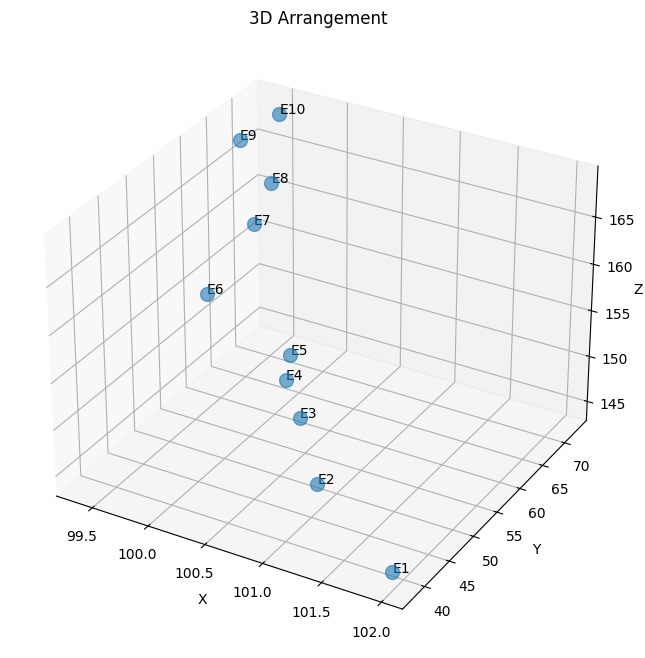

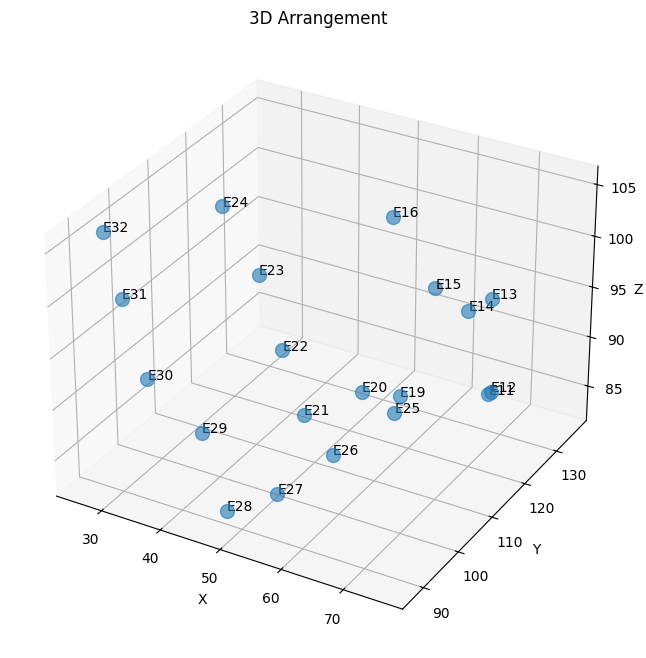

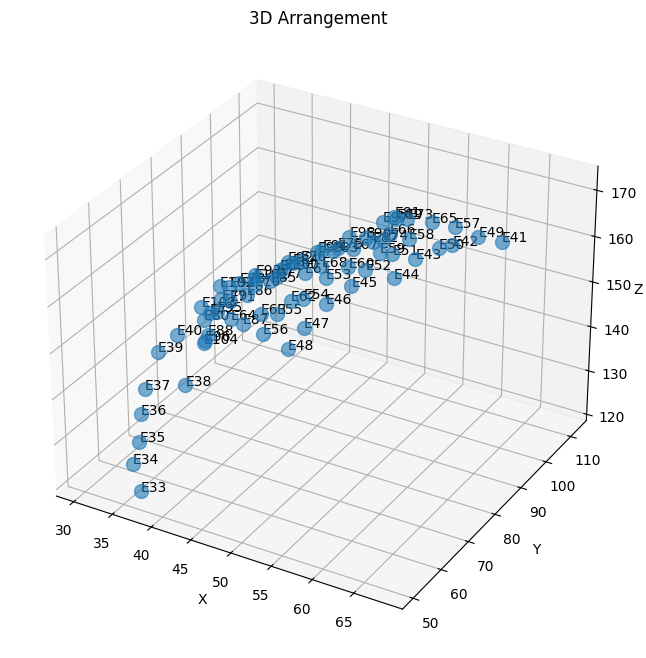

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming your DataFrame 'electrode_df' is already loaded and processed

# Iterate over each unique label to plot
for label in electrode_df['label'].unique():
    # Filter the dataframe for the current label
    filtered_df = electrode_df[electrode_df['label'] == label]

    # Visualization in 3D
    fig = plt.figure(figsize=(10, 8))  # The overall canvas size
    ax = fig.add_subplot(111, projection='3d')
    
    # Plotting and labeling each point with its electrode ID
    for index, row in filtered_df.iterrows():
        x, y, z, electrode_id = row['X'], row['Y'], row['Z'], row['electrode_number']
        ax.scatter(x, y, z, label=f'Label {label}' if index == 0 else "", color='#1f77b4', s=100, alpha=0.6)  # To avoid duplicate labels in the legend
        ax.text(x, y, z, f'E{electrode_id}', color='black', fontsize=10)  # Add text label
    
    # Setting labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z', labelpad=-0.7)

    plt.title(f'3D Arrangement', fontsize=12, loc='center')
    plt.show()


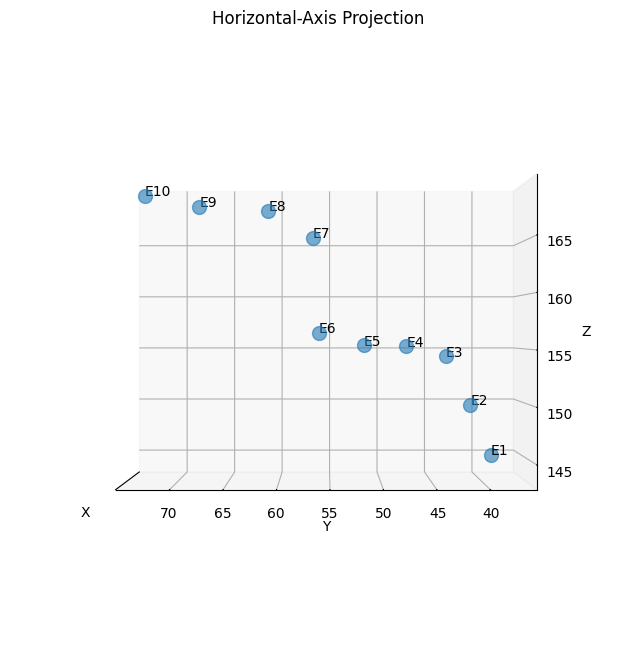

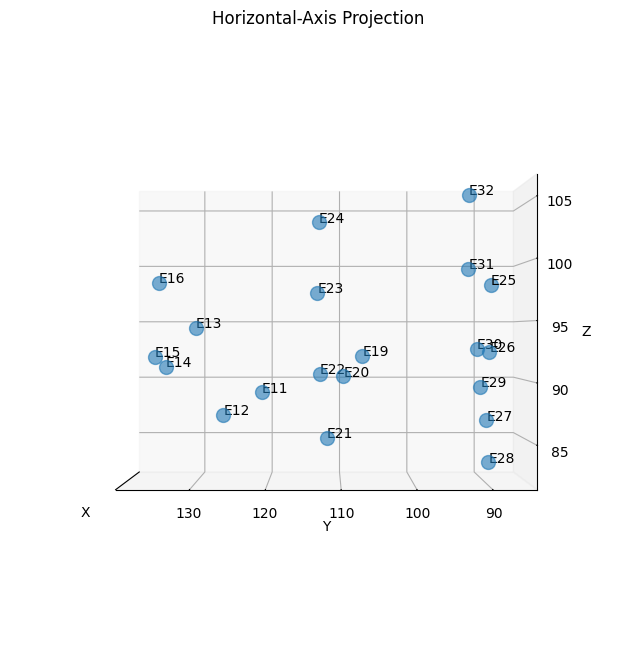

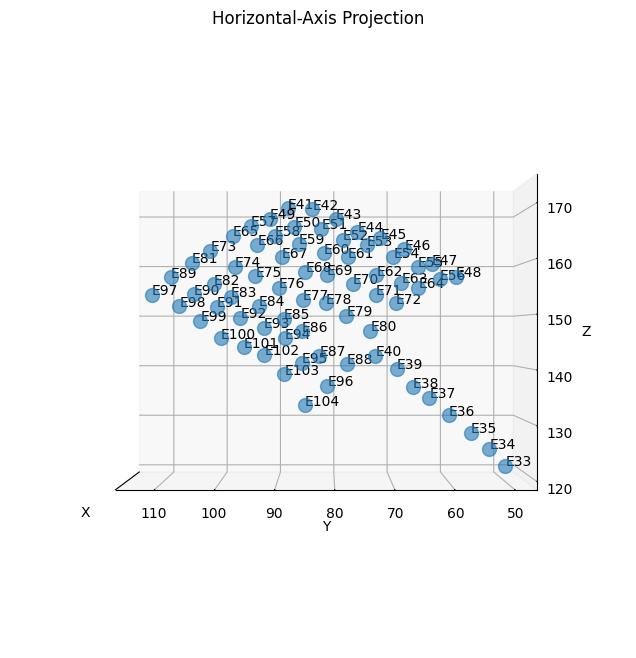

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming your DataFrame 'electrode_df' is already loaded and processed

# Iterate over each unique label to plot
for label in electrode_df['label'].unique():
    # Filter the dataframe for the current label
    filtered_df = electrode_df[electrode_df['label'] == label]

    # Visualization in 3D
    fig = plt.figure(figsize=(10, 8))  # The overall canvas size
    ax = fig.add_subplot(111, projection='3d')
    
    # Plotting and labeling each point with its electrode ID
    for index, row in filtered_df.iterrows():
        x, y, z, electrode_id = row['X'], row['Y'], row['Z'], row['electrode_number']
        ax.scatter(x, y, z, label=f'Label {label}' if index == 0 else "", color='#1f77b4', s=100, alpha=0.6)  # To avoid duplicate labels in the legend
        ax.text(x, y, z, f'E{electrode_id}', color='black', fontsize=10)  # Add text label
    
    # Setting labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_xticks([])
    ax.view_init(elev=0, azim=180)  
    plt.title(f'Horizontal-Axis Projection', fontsize=12, loc='center')
    plt.show()
